# Chebyshev fit to light curves

In [1]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import matplotlib.cm as cm
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
from sympy.solvers import solve
from sympy import Symbol
import sympy
from numpy.polynomial.chebyshev import chebfit,Chebyshev, chebval
%matplotlib inline

In [2]:

home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc/'
direc = os.listdir(temp)

In [3]:
def calc_chisq(lightcurve,fx):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / fx).sum()
    
    return chisq

In [4]:
# Smoothing the data

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [5]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    return baseline, event, it0

In [6]:
# Reading in one single lightcurve

f = '/ulwdc1_005_W149.txt' #non-binary
f2 = '/ulwdc1_144_W149.txt' #binary

t,m,e = np.loadtxt(temp+f,unpack=True)
t2,m2,e2 = np.loadtxt(temp+f2,unpack=True)


df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
peaks = np.array([t[np.argmin(m)]])

df2 = pd.DataFrame({'t': t2, 'magnitude': m2, 'm_err': e2})
peaks2 = np.array([t2[np.argmin(m2)]])

dt =50

In [7]:
baseline, event, it0 = localize_event(df['t'], peaks[0],10)
baseline2, event2, it02 = localize_event(df2['t'], peaks2[0],10)

In [8]:
base_mag = np.median(df['magnitude'][baseline])
df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))

base_mag2 = np.median(df2['magnitude'][baseline2])
df2['A'] = 10 ** (0.4*(base_mag2 - df2['magnitude']))

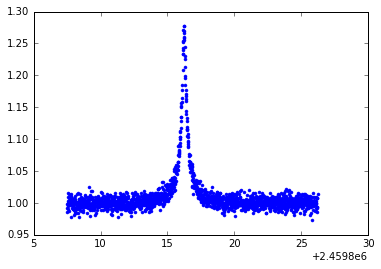

In [9]:
plt.plot(df['t'][event],df['A'][event],'b.')
#plt.gca().invert_yaxis()


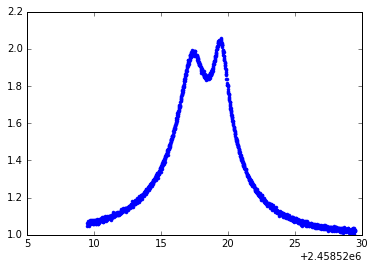

In [10]:
plt.plot(df2['t'][event2],df2['A'][event2],'b.')
#plt.gca().invert_yaxis()

In [11]:
t_new = df['t'][event]#df['t'][(df['t']>peaks[0]-dt) & (df['t']<peaks[0]+dt)]
m_new = df['A'][event]#df['magnitude'][(df['t']>peaks[0]-dt) & (df['t']<peaks[0]+dt)]

t_new2 = df2['t'][event2]#df['t'][(df['t']>peaks[0]-dt) & (df['t']<peaks[0]+dt)]
m_new2 = df2['A'][event2]#df['magnitude'][(df['t']>peaks[0]-dt) & (df['t']<peaks[0]+dt)]

In [12]:
t_scaled = np.interp(t_new, (t_new.min(), t_new.max()), (-1, +1))
m_scaled = np.interp(m_new, (m_new.min(), m_new.max()), (-1, +1))

t_scaled2 = np.interp(t_new2, (t_new2.min(), t_new2.max()), (-1, +1))
m_scaled2 = np.interp(m_new2, (m_new2.min(), m_new2.max()), (-1, +1))

In [14]:
res = chebfit(t_scaled,m_new,50)
res2 = chebfit(t_scaled2,m_new2,50)

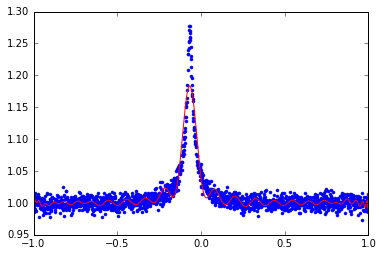

In [15]:
plt.plot(t_scaled,m_new,'b.')
plt.plot(t_scaled,chebval(t_scaled,res),'r-')
#plt.plot(t_scaled,chebval(t_scaled,res)-(res[0]/2),'g-')

#plt.gca().invert_yaxis()


In [368]:
chebval(t_scaled,res)[0]

0.9948161266973992

In [369]:
np.sum((res/res[0])**2)-1

0.0014756234710999738

In [370]:
np.std(res2[1:])

0.056418597378322874

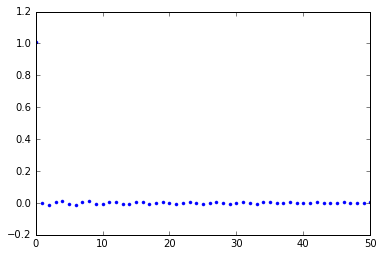

In [371]:
plt.plot(res,'b.')

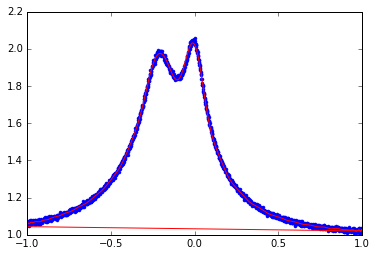

In [16]:
plt.plot(t_scaled2,m_new2,'b.')
plt.plot(t_scaled2[0:],chebval(t_scaled2,res2)[0:],'r-')
#plt.plot(t_scaled,chebval(t_scaled,res)-(res[0]/2),'g-')

#plt.gca().invert_yaxis()



In [373]:
chebval(t_scaled2,res2)[-1]

1.0553574787533808

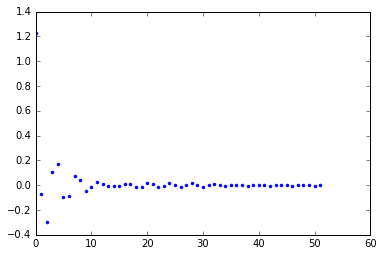

In [374]:
plt.plot(res2, 'b.')

In [375]:
np.sum((res2/res2[0])**2)-1

0.10817456445758644

In [376]:
np.std(res2[1:])

0.056418597378322874

In [72]:
# Defining the function to fit Chebyshev light curves

def chebyshevfit (t,m, order= 50):
    
    # x's should be converted to the interval [-1,1]
    
    t_scaled = np.interp(t, (t.min(), t.max()), (-1, +1))
    #m_scaled = np.interp(m, (m.min(), m.max()), (-1, +1))
    
    res = chebfit(t_scaled,m,order)
    
    #metric = np.sum(((res)-(base))**2)
    
    chi_2 = calc_chisq(m, chebval(t_scaled,res) )
    
    #a_n_sq = np.sum(res**2)
    
    #ave = np.average(res[1:49])
    
    return res, chi_2

In [73]:
#Trying it on Data Challenge light curves


# Res_base is a base light curve whose Chebyshev coefficients will be compared to other light curve fits
res_base = res2

direc.sort()
result = {'name':[], 'a_n':[], 'metric':[], 'chi_2':[], 'a_n_sq':[], 'ave':[]}
dt = 50

for f in direc:
    
    if f.endswith('.txt') and f.split('_')[2].startswith('W'):
        
        t,m,e = np.loadtxt(temp+str(f),unpack=True)
        
        df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
        
        peaks = t[np.argmin(m)]
        
        baseline, event, it0 = localize_event(df['t'], peaks,dt)
        
        base_mag = np.median(df['magnitude'][baseline])
        df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))

        t_new = df['t'][event]#df['t'][(df['t']>peaks-dt) & (df['t']<peaks+dt)]
        m_new = df['A'][event]#df['magnitude'][(df['t']>peaks-dt) & (df['t']<peaks+dt)] 
        
        res, metric, chi_2, a_n_sq, ave = chebyshevfit(t_new,m_new,  res_base, order=50)
        
        
        
        result['name'].append(f)
        result['a_n'].append(res)
        result['metric'].append(metric)
        result['chi_2'].append(chi_2)
        result['a_n_sq'].append(a_n_sq)
        result['ave'].append(ave)

print 'done'




TypeError: chebyshevfit() got multiple values for keyword argument 'order'

In [150]:
temp = home+'/Desktop/'
direc = os.listdir(temp+'/alllc1/')

In [151]:
info = pd.read_csv(temp+'/trial_runs/alllc_full_info_w_smoothing.CSV')

In [153]:
#Trying it on Data Challenge light curves


# Res_base is a base light curve whose Chebyshev coefficients will be compared to other light curve fits
res_base = res2

direc.sort()
result = {'name':[], 't':[], 'mag':[], 'a_n':[], 'chi_2':[], 'q':[], 'rho':[], 'tE':[], 't0':[], 'u0':[]}
dt = 50

for c, name in enumerate(info['name']):
    
    if name in direc:
        print c
        
        t,f,f_err,f_true,code = np.loadtxt(temp + '/alllc1/' + str(name),usecols=(0,1,2,3,5),unpack=True)
        df = pd.DataFrame({'t':t , 'A':f , 'f_err' : f_err , 'f_true': f_true, 'code':code})
        df = df[df['code']==4]
        
        t = t[np.where(code==4)]
        f = f[np.where(code==4)]
        peaks = t[np.argmax(f)]
        
        baseline, event, it0 = localize_event(t, peaks,dt)
        
        #base_mag = np.median(df['A'][baseline])
        #df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))

        t_new = t[event]#df['t'][(df['t']>peaks-dt) & (df['t']<peaks+dt)]
        m_new = f[event]#df['magnitude'][(df['t']>peaks-dt) & (df['t']<peaks+dt)] 
        
        res, chi_2 = chebyshevfit(t_new,m_new, order=50)
        
        
        
        result['name'].append(name)
        result['t'].append(t)
        result['mag'].append(f)
        result['a_n'].append(res)
        result['chi_2'].append(chi_2)
        result['q'].append(info['q_true'][c])
        result['rho'].append(info['rho'][c])
        result['tE'].append(info['tE_true'][c])
        result['t0'].append(info['t0_true'][c])
        result['u0'].append(info['u0_true'][c])
        
        #if c == 1000:
        #    break

print 'done'





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [179]:
x = []
for i in range (len(result['a_n'])):
    x.append(np.sum(result['a_n'][i]**2))

In [180]:
x = np.asarray(x)

In [181]:
df= pd.DataFrame({'name':result['name'] , 'q': result['q'] , 'rho': result['rho'] , 'a_n_2': x,
                  'u0': result['u0'] , 'chi_2': result['chi_2'] , 'tE': result['tE'] , 't0': result['t0']})

In [7]:
df = pd.read_csv('alllc1_chebyshev_fit_info.CSV')

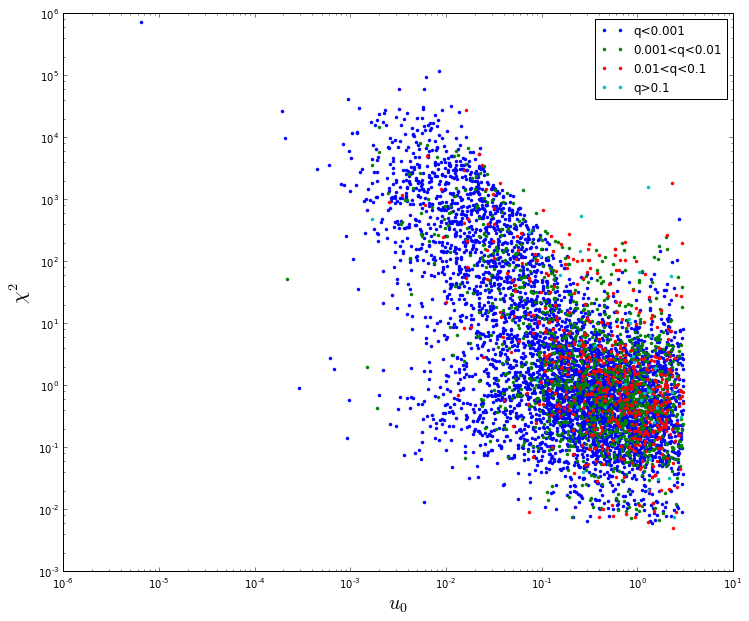

In [8]:
#plt.plot((df['u0']),df['chi_2'],'.', label='all q')
plt.plot(df['u0'][df['q']<0.001],df['chi_2'][df['q']<0.001],'.',
        label='q<0.001')
plt.plot(df['u0'][(df['q']<0.01) & (df['q']>0.001) ],df['chi_2'][(df['q']<0.01) & (df['q']>0.001)],'.',
        label='0.001<q<0.01')
plt.plot(df['u0'][(df['q']<0.1) & (df['q']>0.01) ],df['chi_2'][(df['q']<0.1) & (df['q']>0.01)],'.',
        label='0.01<q<0.1')
plt.plot(df['u0'][df['q']>0.1],df['chi_2'][df['q']>0.1],'.',
        label='q>0.1')

plt.legend()
plt.xlabel('$u_0$', size=20)
plt.ylabel('${\chi}^2$', size=20)
plt.yscale('log')
plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

In [29]:
bins1 = np.linspace(np.log10(df.u0).min(),np.log10(df.u0).max(),10)

In [30]:
groups1 = df.groupby(np.digitize(np.log10(df.u0), bins1))

In [31]:
bins2 = np.linspace(np.log10(df.chi_2).min(),np.log10(df.chi_2).max(),10)

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [32]:
groups2 = df.groupby(np.digitize(np.log10(df.chi_2), bins2))

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(0.1, 734470.7076417523)

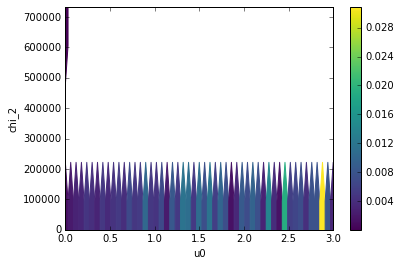

In [54]:

ax = df.plot.hexbin(x='u0',
                     y='chi_2',
                     C='q',
                
                     gridsize=50,
                     cmap="viridis")
plt.ylim(0.1,max(df['chi_2']))
#plt.yscale('log')

In [43]:
q_sum = []

for i in groups1.indices:
    #print df['q'][groups2.indices[j]]
    for j in groups2.indices:
        if df['q'][groups2.indices[j]] in df['q'][groups1.indices[i]]:
            print 'yes'
        else:
            print 'no'
#         #q_sum.append(len(df['q'][df['q']>0.01][groups1.indices[i]][groups2.indices[j]])/float(len(df['q'][df['q']<0.01][groups1.indices[i]][groups2.indices[j]])))
#         try:
#             print df['q'][groups1.indices[i]]#[groups2.indices[j]])
#         except KeyError:
#             print 0
#             print'\n'
#         #print df['q'][groups2.indices[j]]
    

TypeError: 'Series' objects are mutable, thus they cannot be hashed

TypeError: 'float' object has no attribute '__getitem__'

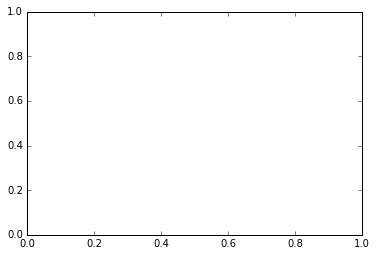

In [14]:
from matplotlib import cm as CM

# X, Y = NP.meshgrid(x, y)
# Z1 = ML.bivariate_normal(X, Y, 2, 2, 0, 0)
# Z2 = ML.bivariate_normal(X, Y, 4, 1, 1, 1)
# ZD = Z2 - Z1
# x = X.ravel()
# y = Y.ravel()
# z = ZD.ravel()
gridsize=30
plt.subplot(111)

x = df['u0']
y = df['chi_2']
z = chi_q

# if 'bins=None', then color of each hexagon corresponds directly to its count
# 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# the result is a pure 2D histogram 

plt.hexbin(x, y, C=z, gridsize=gridsize, cmap=CM.jet, bins=None)
plt.axis([x.min(), x.max(), y.min(), y.max()])

cb = plt.colorbar()
cb.set_label('mean value')


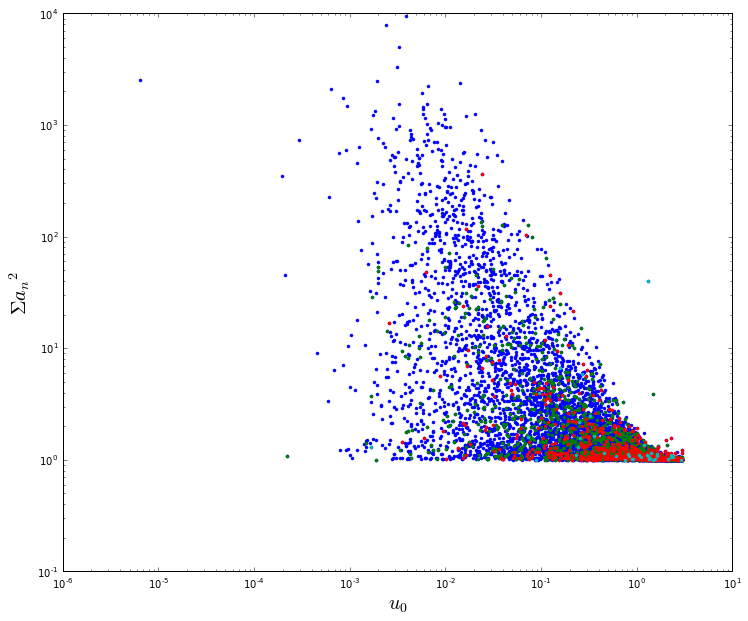

In [182]:
plt.plot((df['u0']),df['a_n_2'],'.')
plt.plot(df['u0'][(df['q']<0.01) & (df['q']>0.001) ],df['a_n_2'][(df['q']<0.01) & (df['q']>0.001)],'.')
plt.plot(df['u0'][(df['q']<0.1) & (df['q']>0.01) ],df['a_n_2'][(df['q']<0.1) & (df['q']>0.01)],'.')
plt.plot(df['u0'][df['q']>0.1],df['a_n_2'][df['q']>0.1],'.')


plt.xlabel('$u_0$', size=20)
plt.ylabel('$\Sigma{a_n}^2$', size=20)
plt.yscale('log')
plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

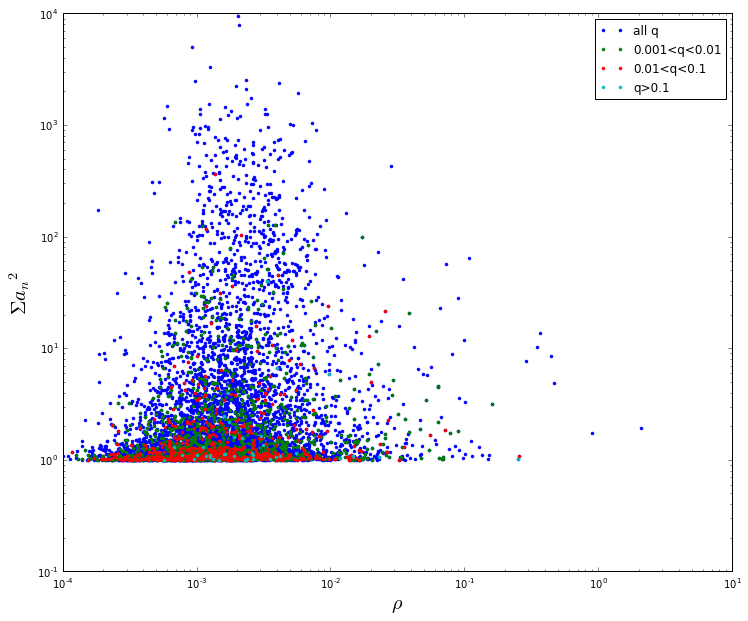

In [187]:
plt.plot((df['rho']),df['a_n_2'],'.', label='all q')
plt.plot(df['rho'][(df['q']<0.01) & (df['q']>0.001) ],df['a_n_2'][(df['q']<0.01) & (df['q']>0.001)],'.',
        label='0.001<q<0.01')
plt.plot(df['rho'][(df['q']<0.1) & (df['q']>0.01) ],df['a_n_2'][(df['q']<0.1) & (df['q']>0.01)],'.',
        label='0.01<q<0.1')
plt.plot(df['rho'][df['q']>0.1],df['a_n_2'][df['q']>0.1],'.',
        label='q>0.1')

plt.legend()
plt.xlabel(r'$\rho$', size=20)
plt.ylabel('$\Sigma{a_n}^2$', size=20)
plt.yscale('log')
plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


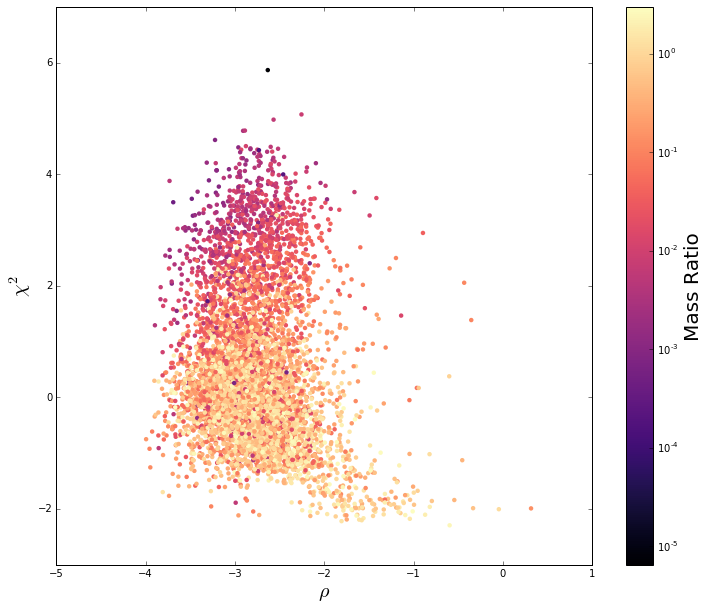

In [223]:
X = np.log10(df['rho'])
Y = np.log10(df['chi_2'])
Z = df['u0']


points = plt.scatter(X,Y, c = Z,cmap="magma", lw=0,norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar(points)
cbar.ax.set_ylabel('Mass Ratio', size=20)


#plt.legend()
plt.xlabel(r'$\rho$', size=20)
plt.ylabel('${\chi}^2$', size=20)
# plt.yscale('log')
# plt.xscale('log')

fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

In [195]:
df.to_csv('alllc1_chebyshev_fit_info.CSV')